In [9]:
import numpy as np
import scipy.io as spio
import scipy.stats as stats
import math
import time
import matplotlib.pyplot as plt

class Node:
    def __init__(self,feature,threshold,left,right,label):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.label=label

def calculate_max_label_count(labels):
    count_map={}
    for i in range(len(labels)):
        if not(labels[i] in count_map):
            count_map[labels[i]]=1
        else:
            count_map[labels[i]]=count_map[labels[i]]+1
            
     ##check this       
    return max(count_map.values())
        
def calculate_max_label(labels):
    count_map={}
    curr_max=0
    max_label=0
    for i in range(len(labels)):
        if not(labels[i] in count_map):
            count_map[labels[i]]=1
        else:
            count_map[labels[i]]=count_map[labels[i]]+1
        if(count_map[labels[i]]>curr_max):
            curr_max=count_map[labels[i]]
            max_label=labels[i]
     ##check this       
    return max_label

def entropy(labels):
    if labels is None or len(labels)==0:
        return 0;
    return (len(labels)-calculate_max_label_count(labels))*1.0*(1.0/len(labels))
    
def shuffle_and_split(data,partition):
    ran_order = np.arange(len(data['X']))
    np.random.shuffle(ran_order)
    ran_order_training = ran_order[:(int)(len(data['X'])*partition)] 
    ran_order_test = ran_order[(int)(len(data['X'])*partition):] 
    training_data = data['X'][ran_order_training]
    training_label = data['Y'][ran_order_training]
    test_data = data['X'][ran_order_test]
    test_label = data['Y'][ran_order_test]
    return [training_data,training_label,test_data,test_label]

def calculate_optimal_feature_threshold(feature_space,labels):
    opt_f=0
    opt_t=0
    max_uncert_red=0.0
    
    for f in range(feature_space.shape[1]):
        b=np.linspace(min(feature_space[:,f]), max(feature_space[:,f]), 20)
        # cut off the ends
        b=b[1:-1]
        #a=(max(feature_space[:,f])-min(feature_space[:,f]))/10
        #b=[min(feature_space[:,f])+i*a for i in range(10)]
        for t in b:
            try:
                filter_arr_left = np.array(feature_space[:,f]<t)
                filter_arr_right = np.array(feature_space[:,f]>=t)
                left_labels = np.array(labels)[filter_arr_left].tolist()
                right_labels = np.array(labels)[filter_arr_right].tolist()
            except TypeError:
                print("Error partitioning labels")
          #  left_labels=[]
          #  right_labels=[]
          #  for i in range(len(feature_space)):
          #      if(feature_space[i,f]<t):
          #          left_labels.append(labels[i])
          #      else:
          #          right_labels.append(labels[i])
            if(len(left_labels)==0 or len(right_labels)==0):
                continue
            uncertainty_red = entropy(labels)-(len(left_labels)*1.0/len(labels))*entropy(left_labels) - (len(right_labels)*1.0/len(labels))*entropy(right_labels)
            if(uncertainty_red > max_uncert_red):
                opt_f=f
                opt_t=t
                max_uncert_red=uncertainty_red
    
    return [opt_f,opt_t]

def build_tree(feature_space,labels,param,live_count):
    global tree_depth
    global KKK
    if len(feature_space)<=param or live_count > KKK:
        return Node(None,None,None,None,calculate_max_label(labels))
    
    live_count += 1
    tree_depth = max(tree_depth,live_count)
    #print(live_count)
    
    left_space=[]
    left_labels=[]
    right_space=[]
    right_labels=[]
    
    [f,t]=calculate_optimal_feature_threshold(feature_space,labels)
    #print(f,t)
    if(f==0 and t== 0):
        return Node(None,None,None,None,calculate_max_label(labels))
    
    try:
        filter_arr_left = np.array(feature_space[:,f]<t)
        filter_arr_right = np.array(feature_space[:,f]>=t)
        left_space = np.array(feature_space)[filter_arr_left].tolist()
        right_space = np.array(feature_space)[filter_arr_right].tolist()
        left_labels = np.array(labels)[filter_arr_left].tolist()
        right_labels = np.array(labels)[filter_arr_right].tolist()
    except TypeError:
        print("Error partitioning labels")
        
    #for i in range(len(feature_space)):
    #    if(feature_space[i][f]<t):
    #        
    #        left_space.append(feature_space[i])
    #        left_labels.append(labels[i])
    #    else:
    #        right_space.append(feature_space[i])
    #        right_labels.append(labels[i])
    
    left_node=build_tree(np.array(left_space),left_labels,param,live_count)
    right_node=build_tree(np.array(right_space),right_labels,param,live_count)
    
    return Node(f,t,left_node,right_node,None)
    
    ## find the optimal feature and threshold
    ## split on the optimal feature and threshold
    ## node.left=build_tree(left_space)
    ## node.right=build_tree(right_space)
    ## return node


class DecisionTree:
    
    def __init__(self,num_classes,root):
        self.num_classes=num_classes
        self.root=root

            
    def train_model(self,training_data,labels,param):
        print("------Pre-processing Data-----")
        for i in range(len(training_data)):
            if (i == 0):
                feature_mle_mu = training_data[i]
                self.dim = (training_data[i].shape)[0]
            else:
                feature_mle_mu += training_data[i]
            
        feature_mle_mu = feature_mle_mu * 1.0/len(training_data)
        
        for i in range(len(training_data)):
            x_minus_mu_feature = training_data[i]-feature_mle_mu
            if (i == 0):
                feature_mle_sigma = x_minus_mu_feature**2
            else:
                feature_mle_sigma += x_minus_mu_feature**2
                
        feature_mle_sigma = feature_mle_sigma * 1.0/len(training_data)
        
        keys = np.linspace(0,self.dim-1,self.dim)
        feature_var = list(zip(keys,feature_mle_sigma))
        
        feature_var_sorted = sorted(feature_var, key=lambda f: f[1], reverse = True)
        self.top200 = [int(e[0]) for e in feature_var_sorted[:200]]  
        print("------Done Pre-processing Data -----")
        # slice the data
        training_data = training_data[:,self.top200]
        t0 = time.time()
        self.root=build_tree(training_data,labels,param,0)
        t1 = time.time()
        print ("Total time taken: " + str(t1-t0))
        
    def predict(self,x):
        prediction=None
        curr_node=self.root
        while prediction==None:
            if curr_node.label!= None:
                prediction=curr_node.label
            else:
                if(x[curr_node.feature]<curr_node.threshold):
                    curr_node=curr_node.left
                else:
                    curr_node=curr_node.right
        return prediction
       
    def testing_error(self,test_data,labels):
        misses=0
        test_data = test_data[:,self.top200]
        for i in range(len(test_data)):
            if(self.predict(test_data[i])!=labels[i]):
                misses=misses+1
        return (misses*1.0/len(test_data))
            
        ##Steps:
        ##1: return argmax P[X=x/Y=y]*P[Y=y]
        #Partition = 0.7 for 70-30 split

KKK = 10
tree_depth = 0
mat = spio.loadmat('hw1data.mat', squeeze_me=True)
training_error=[]
test_error=[]
for i in range(10):
    [training_data,training_label,test_data,test_label]=shuffle_and_split(mat,0.70)
    decision_tree= DecisionTree(10,None)
    decision_tree.train_model(training_data,training_label,0)
    training_error.append(decision_tree.testing_error(training_data,training_label))
    test_error.append(decision_tree.testing_error(test_data,test_label))

------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 327.57214999198914
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 267.79276394844055
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 283.4457428455353
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 229.35769605636597
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 288.2136900424957
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 232.41943192481995
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 239.17724227905273
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 244.14679503440857
------Pre-processing Data-----
------Done Pre-processing Data -----
Total time taken: 247.8614490032196
------Pre-processing Data-----
------Done Pre-processing D

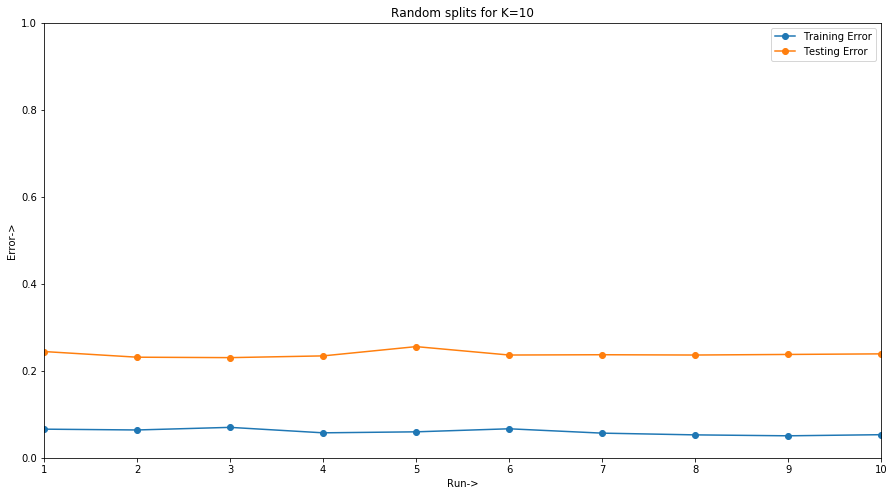

In [15]:
plt.plot(range(1,11),training_error,label="Training Error",marker = 'o')
plt.plot(range(1,11),test_error,label="Testing Error", marker ='o')
plt.xlabel("Run->")
plt.ylabel("Error->")
plt.gca().set_ylim([0,1])
plt.gca().set_xlim([1,10])
plt.gcf().set_size_inches(15,8)
plt.legend()
plt.title("Random splits for K=10")
plt.show()
plt.savefig("q6p3.png")

In [20]:
print (np.mean(test_error))
print (np.mean(training_error))

print (np.std(test_error))
print (np.std(training_error))

0.238233333333
0.0596857142857
0.00689935584755
0.00633158586705
